In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bilinear2 = open('../models/meta-bilinear.txt', 'r').read()
resnet_baseline = open('../models/resnet50-added-augmentations.txt', 'r').readlines()
densenet_baseline = open('../models/densenet169-no-meta.txt', 'r').read()
additive_add = open('../models/resnet50-additive-add.txt', 'r').read()

deleted = re.compile(r'23/23.*')
train_densenet = re.compile(r'Fold: ([0-9]).*Epoch.+([0-9]{1,2}).*\n.*CELoss:.(\d\.\d+).-.F1_Score:.(\d\.\d+).-.Accuracy:.(\d\.\d+)')
val_densenet = re.compile(r'Fold: ([0-9]).*Epoch.+([0-9]{1,2}).*\n.*val_CELoss:.([0-9]\.[0-9]+).-.val_F1_Score:.([0-9]\.[0-9]+).-.val_Accuracy:.([0-9]\.[0-9]+)')
re_train_metrics = re.compile(r'Fold: ([0-9])...Epoch.([0-9]{1,2}).*\n.*CELoss:.(\d\.\d+).-.F1_Score:.(\d\.\d+).-.Accuracy:.(\d\.\d+)')
val_bi_metrics = re.compile(r'Fold: ([0-9])...Epoch.([0-9]{1,2}).*\n.*val_CELoss:.([0-9]\.[0-9]+).-.val_F1_Score:.([0-9]\.[0-9]+).-.val_Accuracy:.([0-9]\.[0-9]+)')

In [3]:
for idx, item in enumerate(resnet_baseline):
    if re.search(deleted, item) is not None:
        resnet_baseline[idx] = re.search(deleted, item).group(0)
resnet_baseline = ''.join(resnet_baseline)

In [4]:
def tokenize(results, ptrn):
    metrics = re.findall(ptrn, results)
    metrics_df = pd.DataFrame(metrics, columns=['fold', 'epoch', 'loss', 'f1', 'acc'])
    metrics_df = metrics_df.apply(lambda x: [float(v) for v in x])
    metrics_df.epoch = metrics_df['epoch'].apply(lambda x: int(x)-1)
    return metrics_df

train_meta = tokenize(bilinear2, re_train_metrics)
val_meta = tokenize(bilinear2, val_bi_metrics)

train_resnet = tokenize(resnet_baseline, re_train_metrics)
val_resnet = tokenize(resnet_baseline, val_bi_metrics)

train_add = tokenize(additive_add, re_train_metrics)
val_add = tokenize(additive_add, val_bi_metrics)

train_dense = tokenize(densenet_baseline, train_densenet)
val_dense = tokenize(densenet_baseline, val_densenet)

In [5]:
val_dense

,fold,epoch,loss,f1,acc
0,1.0,-1,1.1709,0.5949,0.6310
1,1.0,6,0.6756,0.7859,0.8002
2,1.0,5,0.5417,0.7212,0.8015
3,1.0,5,0.3993,0.8617,0.8646
4,1.0,0,0.4051,0.8701,0.8539
...,...,...,...,...,...
244,5.0,3,0.3612,0.9086,0.9010
245,5.0,3,0.3131,0.8937,0.9010
246,5.0,3,0.3759,0.8218,0.8646
247,5.0,3,0.4020,0.8584,0.8854


In [6]:
epochs = [i % 50 for i in range(250)]
train_dense.epoch = epochs
val_dense.epoch = [i % 50 for i in range(len(val_dense))]

In [35]:
def plot_combined(title, ylabel, metric, dfs, ax):
    sns.lineplot(x='epoch', y=metric, data=dfs[0], ax=ax)
    sns.lineplot(x='epoch', y=metric, data=dfs[1], ax=ax)
    ax.legend(['Training', 'Validation'], fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

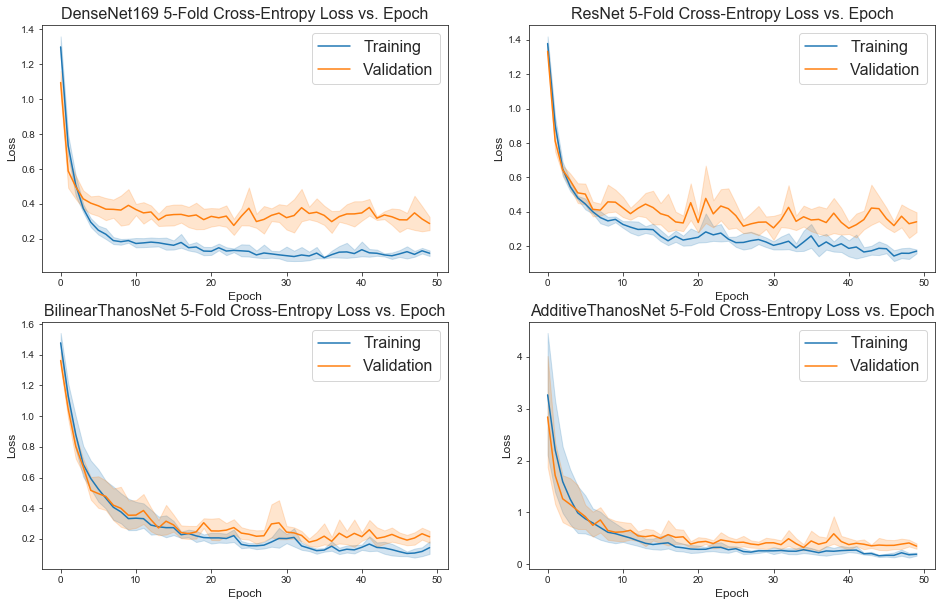

In [36]:
sns.set_style('white')
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
# plt.subplots_adjust(bottom=)
plot_combined('DenseNet169 5-Fold Cross-Entropy Loss vs. Epoch',
              'Loss', 'loss', [train_dense, val_dense], axes[0,0])

plot_combined('ResNet 5-Fold Cross-Entropy Loss vs. Epoch',
              'Loss', 'loss', [train_resnet, val_resnet], axes[0,1])

plot_combined('BilinearThanosNet 5-Fold Cross-Entropy Loss vs. Epoch',
              'Loss', 'loss', [train_meta, val_meta], axes[1,0])

plot_combined('AdditiveThanosNet 5-Fold Cross-Entropy Loss vs. Epoch',
              'Loss', 'loss', [train_add, val_add], axes[1,1])

fig.savefig('loss_plot.png', ppi=300)

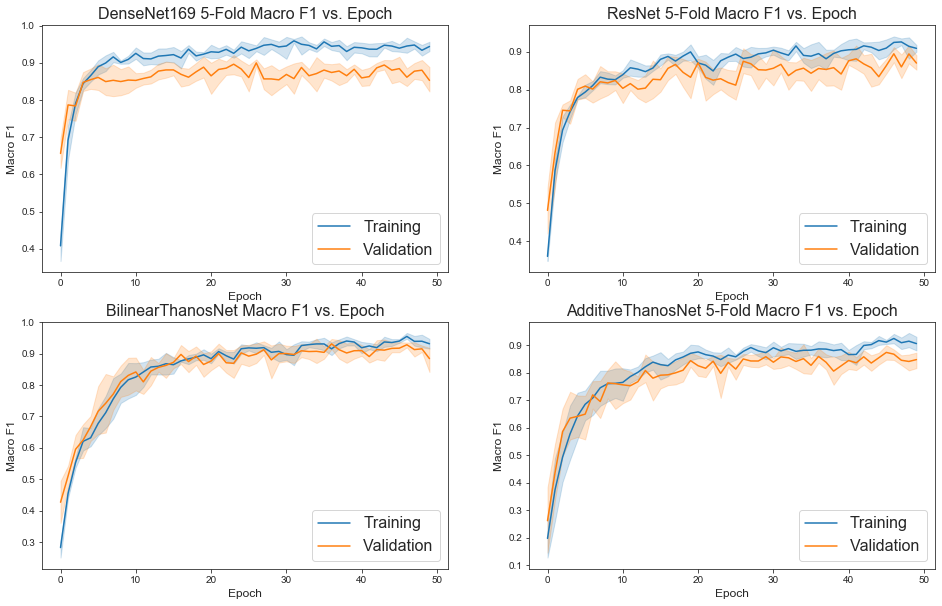

In [37]:
sns.set_style('white')
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

plot_combined('DenseNet169 5-Fold Macro F1 vs. Epoch',
              'Macro F1', 'f1', [train_dense, val_dense], axes[0,0])

plot_combined('ResNet 5-Fold Macro F1 vs. Epoch',
              'Macro F1', 'f1', [train_resnet, val_resnet], axes[0,1])

plot_combined('BilinearThanosNet Macro F1 vs. Epoch',
              'Macro F1', 'f1', [train_meta, val_meta], axes[1,0])

plot_combined('AdditiveThanosNet 5-Fold Macro F1 vs. Epoch',
              'Macro F1', 'f1', [train_add, val_add], axes[1,1])

fig.savefig('f1_plot.png', ppi=300)

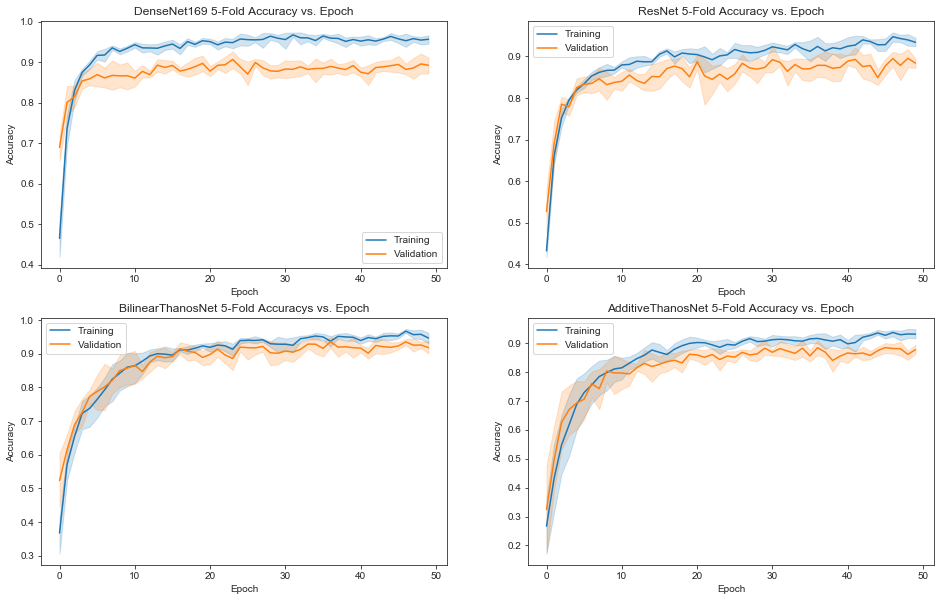

In [159]:
sns.set_style('white')
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

plot_combined('DenseNet169 5-Fold Accuracy vs. Epoch',
              'Accuracy', 'acc', [train_dense, val_dense], axes[0,0])

plot_combined('ResNet 5-Fold Accuracy vs. Epoch',
              'Accuracy', 'acc', [train_resnet, val_resnet], axes[0,1])

plot_combined('BilinearThanosNet 5-Fold Accuracys vs. Epoch',
              'Accuracy', 'acc', [train_meta, val_meta], axes[1,0])

plot_combined('AdditiveThanosNet 5-Fold Accuracy vs. Epoch',
              'Accuracy', 'acc', [train_add, val_add], axes[1,1])

fig.savefig('accuracy_plot.png', ppi=300)
